<b><h1>Clasificador de leucemia</h1></b>


La leucemia es un cáncer de las células primitivas productoras de sangre. Con mayor frecuencia, la leucemia es un cáncer de los glóbulos blancos, pero algunas leucemias comienzan en otros tipos de células sanguíneas.

<br>
<center>
 <img src="https://www.topdoctors.mx/files/Image/large/0ef881bc5e934654d745ee3342bdbfe3.jpg" alt="Leucemia-No leucemia" width="400" height="250">
</center>

# **Librerías**


In [1]:
import os
from __future__ import division, print_function, unicode_literals #py2 and py3
import cv2 as cv2
from PIL import Image
import numpy as np
from PIL import Image, ImageChops, ImageEnhance, ImageOps
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from IPython.display import Image
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import keras.utils as image
import cv2
import cv2 as cv
from PIL import Image
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split

# **Montar drive**


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Proyecto IA')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Proyecto IA


# **Dataset**

In [3]:
d = pd.read_csv('C-NMC_test_prelim_phase_data_labels.csv')
d

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1
...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1
1863,UID_55_24_1_all.bmp,1864.bmp,1
1864,UID_H32_20_1_hem.bmp,1865.bmp,0
1865,UID_54_30_2_all.bmp,1866.bmp,1


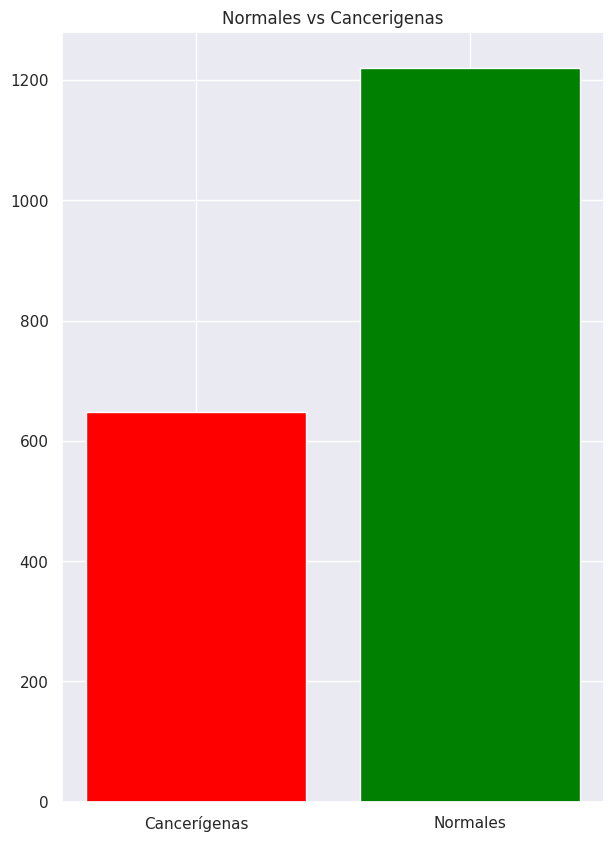

In [4]:
a = (d['labels'] == 0).sum()
b = (d['labels'] == 1).sum()
c = a+b
val = [a,b]
labels = ['Cancerígenas','Normales']
ind = range(len(val))
colores = ['red', 'green']
plt.figure(figsize=(7, 10))
plt.bar(ind,val, color = colores)
plt.xticks(ind,labels)
plt.title('Normales vs Cancerigenas')
plt.show()

In [5]:
imgs = []

path = 'C-NMC_test_prelim_phase_data'
img_size = 128


for img in os.listdir(path):

  img = cv2.imread(os.path.join(path, img))
  #img_gray = cv.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray = cv2.resize(img,(img_size,img_size))
  img_gray = np.transpose(img_gray)
  imgs.append((img_gray.flatten()))
  img_resized = cv2.resize(img_gray, (img_size, img_size))

dataset = np.array(imgs)
dataset_pd = pd.DataFrame(dataset)
print('Cada Imagen tiene '+ str(dataset.shape[1])+ ' pixeles')

Cada Imagen tiene 49152 pixeles


In [6]:
dataset_pd.shape

(1867, 49152)

# **Modelos de clasificación**

### **GaussianNB**


In [ ]:
labels_dataset = pd.read_csv('C-NMC_test_prelim_phase_data_labels.csv')
aaa = labels_dataset

labels = np.array(aaa['labels'].values)
last_column = dataset_pd.shape[1]-1

dataset_pd['labels'] = labels

X = dataset_pd.values[:,:-1]
y = dataset_pd.values[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
est = GaussianNB()
est.fit(X_train,y_train)
predicciones = est.predict(X_test)
print("accuracy test: %.8f"%accuracy_score(est.predict(X_test), y_test))
print("accuracy train: %.8f"%accuracy_score(est.predict(X_train), y_train))

accuracy test: 0.37165775
accuracy train: 0.37977227


In [ ]:
score = cross_val_score(est, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score)) #Esto quiere decir que hacemos 10 entrenamientos independientes.
print("accuracy score: %.8f (+/- %.5f)"%(np.mean(score), np.std(score))) #El Accuracy final será el promedio de las 10 accuracies anteriores.

accuracy score: 0.36153317 (+/- 0.02364)


In [ ]:
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.36      0.96      0.52       133
           1       0.69      0.05      0.09       241

    accuracy                           0.37       374
   macro avg       0.52      0.50      0.30       374
weighted avg       0.57      0.37      0.24       374



In [ ]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, predicciones)
print(cnf_matrix)

[[128   5]
 [230  11]]


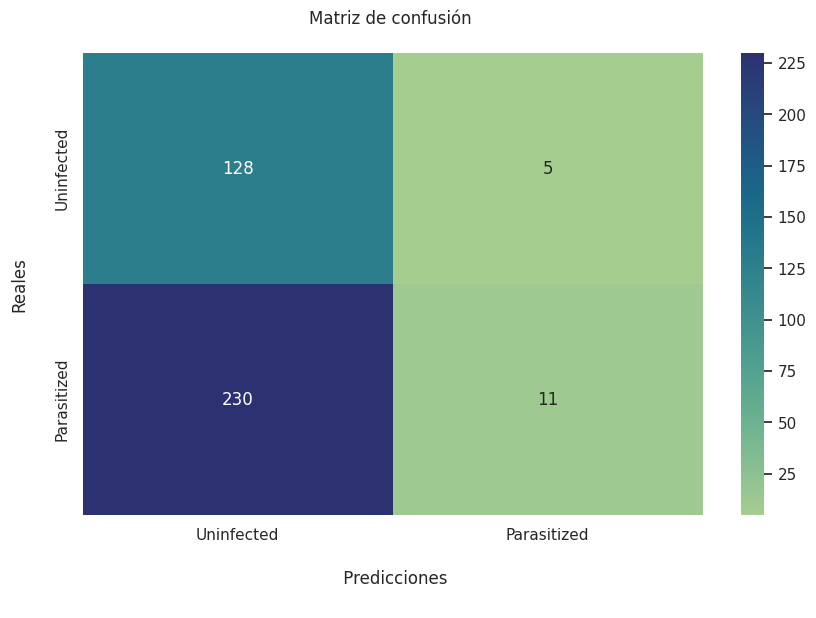

In [ ]:
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test, predicciones), annot=True, fmt=".0f", cmap="crest")
fx.set_title('Matriz de confusión \n');
fx.set_xlabel('\n Predicciones\n')
fx.set_ylabel('Reales\n');
fx.xaxis.set_ticklabels(['Uninfected','Parasitized'])
fx.yaxis.set_ticklabels(['Uninfected','Parasitized'])
plt.show()

### **DecisionTree Classifier**

In [ ]:
def calculate_accuracy_values(X_train, y_train):
    max_depths = np.arange(1, 101)  # Valores de max_depth del 1 al 100
    accuracy_values = np.zeros(len(max_depths))  # Array para almacenar los valores de precisión

    for i, max_depth in enumerate(max_depths):
        classifier = DecisionTreeClassifier(criterion = 'gini', max_depth=max_depth )
        classifier.fit(X_train, y_train)

        accuracy = classifier.score(X_train, y_train)
        accuracy_values[i] = accuracy

    return accuracy_values

In [ ]:
accuracy_values = calculate_accuracy_values(X_train, y_train)
print(accuracy_values)

[0.65505693 0.66309444 0.66979236 0.67916946 0.70261219 0.72739451
 0.74079035 0.75485599 0.79638312 0.8332217  0.85867381 0.88747488
 0.9296718  0.94373744 0.96784997 0.97253851 0.98057602 0.99598125
 0.99933021 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.       

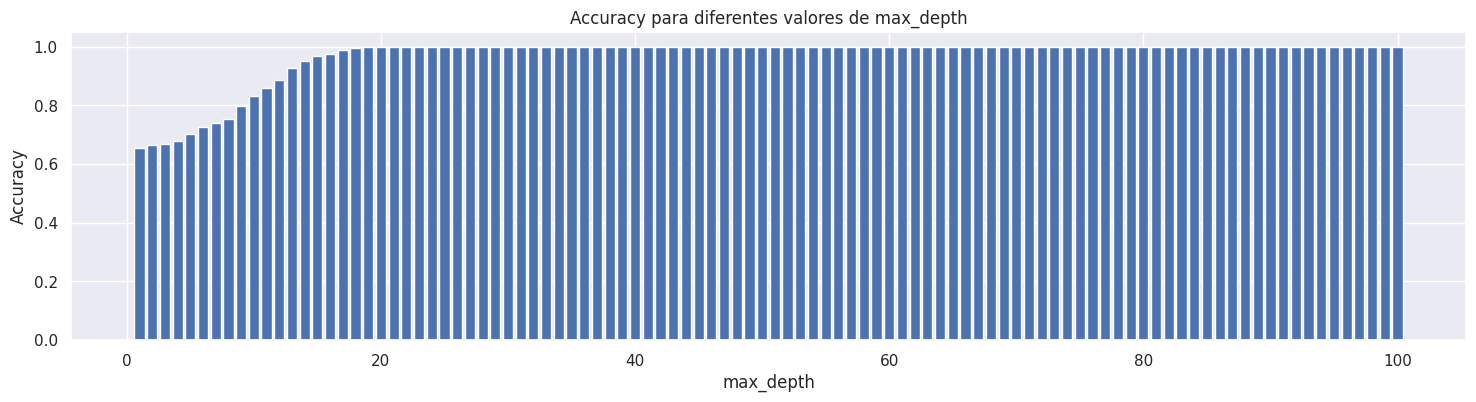

In [ ]:
max_depths = np.arange(1, 101)  # Valores de max_depth del 1 al 100

plt.figure(figsize=[18,4])
plt.bar(max_depths, accuracy_values)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy para diferentes valores de max_depth')
plt.show()

In [ ]:
def calculate_accuracy_values_02(X_train, y_train):
    max_depths = np.arange(1, 1001, 10)  # Valores de max_depth del 1 al 1000 con saltos de 10
    accuracy_values_0 = np.zeros(len(max_depths))  # Array para almacenar los valores de precisión

    for i, max_depth in enumerate(max_depths):
        classifier = DecisionTreeClassifier(max_depth=max_depth)
        classifier.fit(X_train, y_train)

        accuracy = classifier.score(X_train, y_train)
        accuracy_values[i] = accuracy

    return accuracy_values


In [ ]:
accuracy_values_02 = calculate_accuracy_values_02(X_train, y_train)
print(accuracy_values_02)

[0.65505693 0.85800402 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [ ]:
def calculate_accuracy_values_03(X_train, y_train):
    max_depths = np.arange(1, 10001, 100)  # Valores de max_depth del 1 al 1000 con saltos de 10
    accuracy_values = np.zeros(len(max_depths))  # Array para almacenar los valores de precisión

    for i, max_depth in enumerate(max_depths):
        classifier = DecisionTreeClassifier(max_depth=max_depth)
        classifier.fit(X_train, y_train)

        accuracy = classifier.score(X_train, y_train)
        accuracy_values[i] = accuracy

    return accuracy_values

In [ ]:
accuracy_values_03 = calculate_accuracy_values_03(X_train, y_train)
print(accuracy_values_03)

[0.65505693 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


### **Random Forest Classifier**

In [ ]:
from sklearn.model_selection import train_test_split

#Datos train y test

labels_dataset = pd.read_csv('C-NMC_test_prelim_phase_data_labels.csv')
aaa = labels_dataset

labels = np.array(aaa['labels'].values)
last_column = dataset_pd.shape[1]-1

dataset_pd['labels'] = labels

X = dataset_pd.values[:,:-1]
y = dataset_pd.values[:,-1]

#split para entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 21)

print('Cantidad y dimensión de los datos de: \nEntrenamiento: {} \nTest: {}'.format(X_train.shape, X_test.shape))

Cantidad y dimensión de los datos de: 
Entrenamiento: (1493, 49152) 
Test: (374, 49152)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

estimador = RandomForestClassifier(max_depth=6, n_estimators=150, random_state=21)
estimador.fit(X_train, y_train)
predicciones = estimador.predict(X_test)

print("accuracy test: %.3f"%accuracy_score(estimador.predict(X_test), y_test)) #la Exactitud es la cantidad de predicciones positivas que fueron correctas.
print("accuracy train: %.3f"%accuracy_score(estimador.predict(X_train), y_train))

accuracy test: 0.644
accuracy train: 0.701


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

s = cross_val_score(estimador, X_train, y_train, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.655 (+/- 0.01357)


In [ ]:
#¿Por qué ese max depth?
Acu_test = []
Acu_train = []
for i in range(1,10):
    rforest = RandomForestClassifier(max_depth=i)
    rforest.fit(X_train,y_train)
    y_pred = rforest.predict(X_test)
    x_train_pred = rforest.predict(X_train)
    Acu_test.append(round(accuracy_score(y_test,y_pred),4))
    Acu_train.append(round(accuracy_score(y_train,x_train_pred),4))

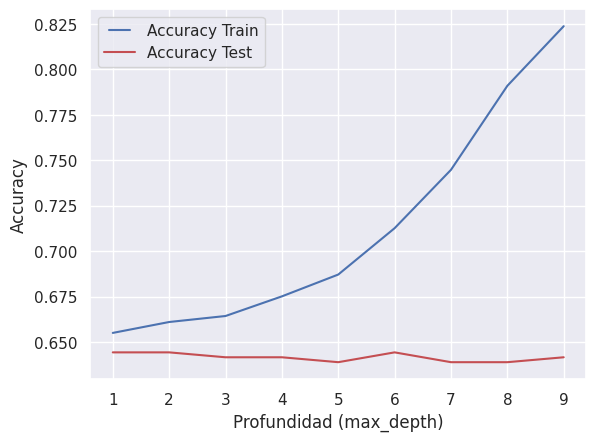

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
max_depths = np.linspace(1, 9, 9, endpoint=True)
line1, = plt.plot(max_depths, Acu_train, "b", label="Accuracy Train")
line2, = plt.plot(max_depths, Acu_test, "r", label="Accuracy Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy")
plt.xlabel("Profundidad (max_depth)")
plt.show()

In [ ]:
Acu_test_random = []
Acu_train_random = []
for i in range(50, 620, 50):
    rforest = RandomForestClassifier(max_depth=6, n_estimators=i)
    rforest.fit(X_train,y_train)
    y_pred = rforest.predict(X_test)
    x_train_pred = rforest.predict(X_train)
    Acu_test_random.append(round(accuracy_score(y_test,y_pred),4))
    Acu_train_random.append(round(accuracy_score(y_train,x_train_pred),4))

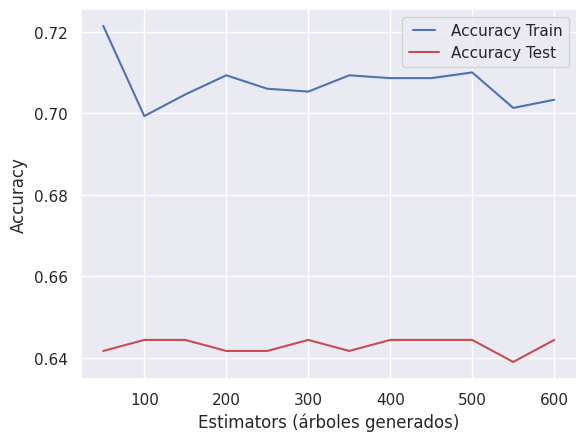

In [ ]:
from matplotlib.legend_handler import HandlerLine2D
max_depths = np.linspace(50, 600, 12, endpoint=True)
line1, = plt.plot(max_depths, Acu_train_random, "b", label="Accuracy Train")
line2, = plt.plot(max_depths, Acu_test_random, "r", label="Accuracy Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy")
plt.xlabel("Estimators (árboles generados)")
plt.show()

### **Supper Vector Machine**

In [ ]:
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
acc = []
acc_train = []
for i in kernels:
  estimador = SVC(kernel=i, random_state=21)
  estimador.fit(X_train, y_train)
  predictions=estimador.predict(X_test)
  acc.append(accuracy_score(estimador.predict(X_test), y_test))
  acc_train.append(accuracy_score(estimador.predict(X_train), y_train))
  print(classification_report(y_test, predictions))
  print(confusion_matrix(y_test, predictions))

j = 0
print("Accuracy scores:\n")
for i in kernels:

  print("Test", i, acc[j])
  print("Train", i, acc_train[j], "\n")
  j = j + 1

              precision    recall  f1-score   support

           0       0.41      0.45      0.43       133
           1       0.68      0.64      0.66       241

    accuracy                           0.57       374
   macro avg       0.55      0.55      0.55       374
weighted avg       0.58      0.57      0.58       374

[[ 60  73]
 [ 86 155]]
              precision    recall  f1-score   support

           0       0.33      0.02      0.03       133
           1       0.64      0.98      0.78       241

    accuracy                           0.64       374
   macro avg       0.49      0.50      0.40       374
weighted avg       0.53      0.64      0.51       374

[[  2 131]
 [  4 237]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.64      1.00      0.78       241

    accuracy                           0.64       374
   macro avg       0.32      0.50      0.39       374
weighted avg       0.42      0.64      0.51       374

[[  0 133]
 [  0 241]]
              precision    recall  f1-score   support

           0       0.33      0.20      0.25       133
           1       0.64      0.78      0.70       241

    accuracy                           0.57       374
   macro avg       0.49      0.49      0.48       374
weighted avg       0.53      0.57      0.54       374

[[ 27 106]
 [ 54 187]]
Accuracy scores:

Test linear 0.5748663101604278
Train linear 1.0 

Test poly 0.6390374331550802
Train poly 0.7052913596784997 

Test rbf 0.6443850267379679
Train rbf 0.6557267247153382 

Test sigmoid 0.5721925133689839
Train sigmoid 0.6008037508372405 



In [ ]:
from sklearn.svm import SVC
estimador = SVC(kernel="rbf")
estimador.fit(X_train, y_train)
predictions=estimador.predict(X_test)
print("accuracy test: %.3f"%accuracy_score(estimador.predict(X_test), y_test)) #la Exactitud es la cantidad de predicciones positivas que fueron correctas.
print("accuracy train: %.3f"%accuracy_score(estimador.predict(X_train), y_train))

accuracy test: 0.644
accuracy train: 0.656


In [ ]:
#Mejor método de calificación el SVC con el kernel RBF
from sklearn.model_selection import cross_val_score
s = cross_val_score(estimador, X_train, y_train, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.655 (+/- 0.01478)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir los valores de los hiperparámetros a probar
param_grid = {'C': [0.1, 1, 10],
              'gamma': [0.1, 0.01, 0.001]}

# Crear el modelo SVC
estimador = SVC(kernel="rbf")

# Realizar la búsqueda en cuadrícula
grid_search = GridSearchCV(estimador, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Hacer predicciones y evaluar el modelo con los mejores parámetros
predictions = best_model.predict(X_test)
print("Best Parameters:", best_params)
print("Accuracy test with best model: %.3f" % accuracy_score(y_test, predictions))

<b>No cargó :C</b>

<br>
<center>
 <img src="https://i.imgur.com/aAyfRd1.png" alt="Leucemia-No leucemia" width="800" height="450">
</center>

### **Decisión**

In [ ]:
#MEJOR METODO DE CALIFICACIÓN POR TIEMPO, RECURSOS Y UN ACCURACY DECENTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

estimador = RandomForestClassifier(max_depth=6, n_estimators=150, random_state=21)
estimador.fit(X_train, y_train)
predicciones = estimador.predict(X_test)

s = cross_val_score(estimador, X_train, y_train, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.654 (+/- 0.02979)
